# Model Development
This notebook shows the process of developing the model. I'll render the git repo README, as it provides the high-level explanation

In [1]:
from IPython.display import display, Markdown

with open('../README.md', 'r') as fh:
    content = fh.read()

display(Markdown(content))

# poverty_prediction
Playing around with multiclass classification of Costa Rican household dataset (https://www.kaggle.com/c/costa-rican-household-poverty-prediction)

## For model development, see
`/notebooks/10_01_model_development.ipynb`
- Algorithm comparison is /notebooks/2018_09_12_compare_algorithms.ipynb

## Important note: 
My goal with this repository is **not to get the best Kaggle score**. I know, crazy, right? I'm more interested in learning best practices, such as building one pipeline for the entire model. Most if not all of the leading kernels (such as https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough) may do pipelines for a couple steps but not for the whole model. Indeed, I scored higher when I did all the transformers (including feature selection) once then scored cross validation on just the final estimator (rather than the entire pipeline).  

## Outline + Lessons (see `/notebooks/10_01_model_development.ipynb`)
- **Feature engineering:** 
    - Manually using logical features hurt the model, the best way seemed to be making many features and automating feature selection (or using a properly regularized estimator) 
- **Learning algorithm comparison**
- **Feature selection:** 
    - `RFECV` seems to be super sensitive to settings, including the classifier used and hyperparameters therein. Even within cross-validation folds (ie, using the same classifier and hyperparameters), I saw between 13 and 143 features selected. This merits further investigation before using in a final pipeline.
    - `SelectFromModel` is much quicker and consistent than `RFECV`, especially given that it exposes an important hyperparameter (`threshold`) for hyperparameter tuning. User note: make sure your feature importances are scaled appropriately for your `threshold`. Oddly, using the final estimator (`BaggedLGBMClassifier`) as the `SelectFromModel` classifier resulted in worse cross-validation scores. 
- **Early stopping + preliminary model evaluation**
    - This was key, though it still results in overfitting
- **Bagging**
    - For simple (and untuned) classification algorithms, bagging had inconsistent results on bias and variance. However, for my implementation of `BaggedLGBMClassifier`, it significantly reduced both bias and variance. Hooray!
    - I ended up writing a **custom sklearn estimator**, `BaggedLGBMClassifier`, because I couldn't figure out a way to use bagging *and* early_stopping with the sklearn API (e.g. `BaggingClassifier`). My implementation uses bagging of 5 `LGBMClassifier` estimators whose early_stopping is determined using the unsampled (aka "out-of-bag") observations as validation set (since bootstrapped sampling of the data leaves ~37% of the data unsampled).
- **Model performance in pipeline**
- **Hyperparameter tuning** 
    - I had mixed success using `Hyperopt` - while it takes a little more setup than `GridSearchCV`, I found it to be very useful and much quicker than `GridSearchCV`. 
    - *However,* I'm curious whether using the base implementation of `Hyperopt` can be dangerous. Unlike `GridSearchCV`, it uses only one train/test split of the data to find optimal hyperparameters - couldn't this lead to overfitting? I'm hoping that my use of bagging for the final estimator will avoid or mitigate potential overfitting. 
    
    
## Next steps
- I haven't yet used sophisticated insights tools for my `BaggedLGBMClassifier`, such as permutation importance, partial dependence plots, and SHAP values. Here is a notebook I've used these tools for a simple Random Forest classifier: https://github.com/zwrankin/chicago_bicycle_share/blob/master/notebooks/2018_09_24_initial_data_exploration_and_models.ipynb
- One of the obstacles to implementing these tools is figuring out how to get feature names out of pipelines with feature selection. 
- Build ensembles with `brew` (https://pypi.org/project/brew/) or `mlens` (https://github.com/flennerhag/mlens)
 
 
 ## Running model: 
 Here is how to fit the tuned model outside of the notebook
```
import os
import sys
import pandas as pd
import pickle

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import pipeline, pipeline_cv_score

X_data = pd.read_hdf('../models/data.hdf', key='X_data')
y_data = pd.read_hdf('../models/data.hdf', key='y_data')
tuned_params = pickle.load(open("../models/tuned_params.p", "rb"))

pipeline.set_params(**tuned_params)

pipeline_cv_score(pipeline, X_data, y_data)

# pipeline.fit(X_data)
# pipeline.predict(TEST_FEATURES_HERE)
```



In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [3]:
#sklearn utilities
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Learning algorithms
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Hyperparameter tuning using optimization
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
# Load from lib
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import kfold, f1_scorer
from lib.model import load_and_process_training_data, load_and_process_test_data
from lib.model import pipeline_cv_score
from lib.visualization import report_cv_scores
from lib.visualization import compare_algorithm_cv_scores, plot_algorithm_cv_scores
from lib.visualization import plot_learning_curve, plot_feature_importances

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
from lib.model import pipeline
pipeline

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('feature_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
         ...dom_state=10, reg_alpha=0.42, reg_lambda=0.36,
           subsample=0.99, subsample_for_bin=40000))])

# Feature engineering
In `lib`, there are a handful of feature engineering functions, including ones that aggregate individual-level characteristics (`feature_engineer_aggregate_individuals`). 
I originally intended to include all feature engineering in the pipeline with the ability to control feature complexity with hyperparamters, and created the custom sklearn transformer `lib.pipeline.FeatureEngineer` which takes in a feature engineering function arg `func` and feature complexity arg `level`, used as follows:
```
from sklearn.pipeline import FeatureUnion
from .preprocessing import feature_engineer_rent, feature_engineer_education, feature_engineer_demographics, feature_engineer_house_rankings, feature_engineer_house_characteristics, feature_engineer_assets
from .pipeline import FeatureEngineer

FeatureUnion(transformer_list=[
    ('extract_rent', FeatureEngineer(feature_engineer_rent, level='low')),
    ('extract_educ', FeatureEngineer(feature_engineer_education, level='low')),
    ('extract_demog', FeatureEngineer(feature_engineer_demographics, level='medium')),
    ('extract_houseq', FeatureEngineer(feature_engineer_house_rankings, level='low')),
    ('extract_housec', FeatureEngineer(feature_engineer_house_characteristics, level='medium')),
    ('extract_assets', FeatureEngineer(feature_engineer_assets, level='low'))
])
```

**However**, I ended up doing all the feature engineering as preprocessing before the pipeline, because
- None of the engineering functions would behave differently in the pipeline
- Aggregation is slow, so doing it in the pipeline significanlty slows training and hyperparameter tuning
- The control over feature complexity wasn't important, as it was better to create many complex features and let feature selection pare density down. 

In [6]:
X_data, y_data = load_and_process_training_data()
y_data = y_data - 1  #normalize to 0 to avoid bugs
X_data.to_hdf('../models/data.hdf', key='X_data')
y_data.to_hdf('../models/data.hdf', key='y_data')

X_data.shape

(2973, 198)

# Learning algorithm comparison
When comparing these untuned models, the simpler models perform better. However, we know from expereinec that gradient boosted algorithms will gain more from hyperparameter tuning, so we will move forward with them. Indeed, this comparison is not very meaningful, but we could revisit with tuning later. 

In [7]:
algs = [RandomForestClassifier, ExtraTreesClassifier,
        GradientBoostingClassifier, LGBMClassifier, XGBClassifier,
        LinearSVC, SVC, GaussianNB, MLPClassifier, LogisticRegressionCV, RidgeClassifierCV, 
       LinearDiscriminantAnalysis, KNeighborsClassifier]

transformer_pipeline = Pipeline(pipeline.steps[:2]) #just want imputer and scaler
transformer_pipeline

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('feature_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [8]:
%%time
model_results = compare_algorithm_cv_scores(transformer_pipeline, algs, X_data, y_data, kfold, f1_scorer)

RandomForestClassifier CV Score: 0.35332 with std: 0.02919
ExtraTreesClassifier CV Score: 0.34897 with std: 0.03835
GradientBoostingClassifier CV Score: 0.28423 with std: 0.07596
LGBMClassifier CV Score: 0.2773 with std: 0.07945
XGBClassifier CV Score: 0.28183 with std: 0.07626
LinearSVC CV Score: 0.27267 with std: 0.06991
SVC CV Score: 0.27848 with std: 0.03909
GaussianNB CV Score: 0.20335 with std: 0.0832
MLPClassifier CV Score: 0.28749 with std: 0.07949
LogisticRegressionCV CV Score: 0.26222 with std: 0.04151
RidgeClassifierCV CV Score: 0.29926 with std: 0.05365
LinearDiscriminantAnalysis CV Score: 0.30419 with std: 0.11003
KNeighborsClassifier CV Score: 0.34518 with std: 0.02546
Wall time: 2min 2s


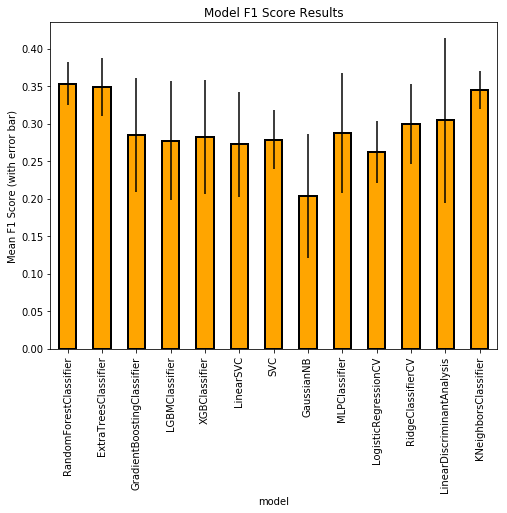

In [9]:
plot_algorithm_cv_scores(model_results)

# Feature selection

In [10]:
def plot_feature_selection(selector):
    """plots recursive feature selection results from a fitted RFECV"""
    n_features = selector.n_features_
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title(f'Feature Selection Scores: best number = {n_features}')
    plt.xlabel("Step")
    plt.ylabel("Cross-validation Macro F1 Score)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()

In [ ]:
%%time
clf = ExtraTreesClassifier(random_state = 10, n_estimators = 100, n_jobs = -1)
selector = RFECV(clf, step=5, cv=kfold, scoring=f1_scorer, n_jobs=-1)

X_transformed = transformer_pipeline.fit_transform(X_data)
# Convert back to dataframe
X_transformed = pd.DataFrame(X_transformed, columns = X_data.columns)

selector.fit(X_transformed, y_data)
plot_feature_selection(selector)

In [ ]:
train_selected = selector.transform(X_transformed)
# Convert back to dataframe
selected_features = X_transformed.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
print(selected_features[:10])

train_X, val_X, train_y, val_y = train_test_split(train_selected, y_data, test_size=0.25,
                                                 random_state=10)

# Save 
train_X.to_hdf('../models/training.hdf', key='train_X')
train_y.to_hdf('../models/training.hdf', key='train_y')
val_X.to_hdf('../models/training.hdf', key='val_X')
val_y.to_hdf('../models/training.hdf', key='val_y')

# Early stopping & preliminary model evaluation
**NOTE** this is sorta cheating, in the sense that we're cross-validating the estimator but NOT the transformers. This will all be in a pipeline later. 

In [ ]:
params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

fit_params = {"eval_set": [(val_X, val_y)], 
              "early_stopping_rounds": 10, 
              "verbose": False}

model = LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

In [ ]:
%%time
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

In [ ]:
model.fit(train_X, train_y, **fit_params)

# Feature importances into a dataframe
features = train_X.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plot_feature_importances(feature_importances, n=30, threshold=0.95)

In [ ]:
%%time
plot_learning_curve(model, 'Learning Curves', train_X, train_y, cv=kfold, scoring=f1_scorer)

# Bagging

In [ ]:
from lib.pipeline import BaggedLGBMClassifier

In [ ]:
bagged_model = BaggedLGBMClassifier(**params)
bagged_model

In [ ]:
%%time
cv_score = cross_val_score(bagged_model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

# Model performance in pipeline
It seems that model performance lags slightly in the full pipeline, but it's hard to tell if it's just noise. It's promising that we weren't overly optimistic. 

In [ ]:
%%time
cv_score = cross_val_score(pipeline, X_data, y_data, cv=kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

# Hyperparameter Tuning using Hyperopt
I have found that different runs get vastly different optimal parameters (even though `random_state` was set for the train/val split. Not sure if there's a way to set seed for `hyperopt`. 

In [ ]:
# need to split using raw data
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25,
                                                 random_state=10)

In [ ]:
from lib.model import pipeline # make sure we reload defaults
params = pipeline.get_params() #use the defaults
def objective(space, params=params, noisy=False):
    if noisy: print(f'Training with params {space}')

    params.update(space)
    # hp.quniform sometimes returns strings (https://github.com/hyperopt/hyperopt/issues/253)
    params['model__num_leaves'] = int(params['model__num_leaves'])
    params['model__min_child_samples'] = int(params['model__min_child_samples'])
    params['model__max_depth'] = int(params['model__max_depth'])

    pipeline.set_params(**params)
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_val)
    score = f1_score(y_val, predictions, average = 'macro')
    
    if noisy: print(f'f1 score: {score}')
    
    return{'loss':1-score, 'status': STATUS_OK }

# Note - may want to widen ranges, but it's slow so I'll keep them narrow for now
space ={'selector__threshold': hp.uniform('selector__threshold', 0.005, 0.015),
        'model__limit_max_depth': hp.choice('model__limit_max_depth', [True, False]),
        'model__max_depth': hp.quniform('model__max_depth', 15, 25, 1), 
        'model__num_leaves': hp.quniform('model__num_leaves', 40, 60, 1),
        'model__min_child_samples':hp.quniform('model__min_child_samples', 12, 18, 1),
        'model__learning_rate': hp.uniform('model__learning_rate', 0.05, 0.1),
        'model__reg_alpha': hp.uniform('model__reg_alpha', 0.3, 0.6),
        'model__reg_lambda': hp.uniform('model__reg_lambda', 0.2, 0.5),
        'model__subsample': hp.uniform('model__subsample', 0.80, 1.0),
        'model__colsample_bytree': hp.uniform('model__colsample_bytree', 0.5, 1.0),
       }

seed = 42
trials = Trials()

In [ ]:
%%capture --no-stdout
%%time
# Seems to run just over 1 min per 10 iterations for full pipeline
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate= np.random.RandomState(seed))

tuned_params = params.copy()
tuned_params.update(best)
tuned_params['model__num_leaves'] = int(tuned_params['model__num_leaves'])
tuned_params['model__min_child_samples'] = int(tuned_params['model__min_child_samples'])
tuned_params['model__max_depth'] = int(tuned_params['model__max_depth'])

In [ ]:
print(best)

In [ ]:
pickle.dump(tuned_params, open("../models/tuned_params.p", "wb"))

In [ ]:
# Final cross-validation score
pipeline.set_params(**tuned_params)
cv_score = cross_val_score(pipeline, X_data, y_data, cv=kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

# Scratch

In [ ]:
# Code to do hyperopt on an estimator (rather than the whole pipeline)

In [ ]:
# def objective(space, params=params, noisy=False):
#     if noisy: print(f'Training with params {space}')

#     params.update(space)
#     # hp.quniform sometimes returns strings (https://github.com/hyperopt/hyperopt/issues/253)
#     params['num_leaves'] = int(params['num_leaves'])
#     params['min_child_samples'] = int(params['min_child_samples'])
#     params['max_depth'] = int(params['max_depth'])
    
#     if params['num_leaves'] <3:
#         import pdb; pdb.set_trace()

#     model = BaggedLGBMClassifier(**params)
    
#     model.fit(train_X, train_y)
#     predictions = model.predict(val_X)
#     score = f1_score(val_y, predictions, average = 'macro')
    
#     if noisy: print(f'f1 score: {score}')
    
#     return{'loss':1-score, 'status': STATUS_OK }

# space ={'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
#         'max_depth': hp.quniform('max_depth', 4, 40, 1), 
#         'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
#         'min_child_samples':hp.quniform('min_child_samples', 5, 15, 1),
#         'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
#         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
#         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
#         'subsample': hp.uniform('subsample', 0.50, 1.0),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),}

# seed = 42
# trials = Trials()

In [ ]:
# %%capture --no-stdout
# %%time
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10,
#             trials=trials,
#             rstate= np.random.RandomState(seed))

# best['num_leaves'] = int(best['num_leaves'])
# best['min_child_samples'] = int(best['min_child_samples'])
# best['max_depth'] = int(best['max_depth'])